In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt','r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [7]:

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update' )
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    
    def __call__(self, x):
        # calculate the forward pairs
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma + xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return (self.gamma, self.beta)
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim))

    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape 
        x = x.view(B, T//n, C*n)
        if x.shape == 1:
            x = x.squeeze(1)
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []
    
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42)


In [9]:
n_embd = 10 # the dimmensionality of the character embedding vector
n_hidden = 200 # the number of hidden layers of the MLP

#  C = torch.randn((vocab_size,n_embd)) # This is being replaced with Embedding
model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(8),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1
parameters = model.parameters() # + [C] THis is not required as we are using Embedding()
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True

22097


In [10]:
ix = torch.randint(0,Xtr.shape[0],(4,)) # lets look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

NameError: name 'n' is not defined

In [37]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

AttributeError: 'Embedding' object has no attribute 'out'

In [22]:
model.layers[0].out.shape # output of Embedding layer

torch.Size([4, 8, 10])

In [23]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [24]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [32]:
(torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200)).shape 

torch.Size([4, 200])

In [27]:
(torch.randn(4,5,6,80) @ torch.randn(80,200) + torch.randn(200)).shape #pytorch multiplies just the last dimmension and the dimension before them are unchanged

torch.Size([4, 5, 6, 200])

In [29]:
(torch.randn(4,4,20) @ torch.randn(20,200) + torch.randn(200)).shape #pytorch multiplies just the last dimmension and the dimension before them are unchanged

torch.Size([4, 4, 200])

In [28]:
#(1 2) (3 4) (5 6) (7 8) 

In [30]:
e =torch.randn(4, 8, 10)  # goal: want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [31]:
(e.view(4,4,20) == explicit).all()

tensor(True)

In [25]:
Xtr

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0, 25],
        [ 0,  0,  0,  ...,  0, 25, 21],
        ...,
        [ 0,  0,  0,  ..., 15, 12,  4],
        [ 0,  0,  0,  ..., 12,  4,  1],
        [ 0,  0,  8,  ...,  4,  1, 14]])

In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  # emb = C[Xb] # embed the characters into vectors
  # x = emb.view(emb.shape[0], -1) # concatenate the vectors
  # x = Xb
  # for layer in layers:
  #   x = layer(x)
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.7744
  10000/ 200000: 2.1249
  20000/ 200000: 2.0351
  30000/ 200000: 2.2305
  40000/ 200000: 2.1205
  50000/ 200000: 2.1085
  60000/ 200000: 2.3959
  70000/ 200000: 1.9446
  80000/ 200000: 2.1776
  90000/ 200000: 2.1761
 100000/ 200000: 1.8403
 110000/ 200000: 2.3710
 120000/ 200000: 2.3212
 130000/ 200000: 2.2722
 140000/ 200000: 2.2061
 150000/ 200000: 2.1215
 160000/ 200000: 1.7728
 170000/ 200000: 2.3401
 180000/ 200000: 1.9840
 190000/ 200000: 1.9258


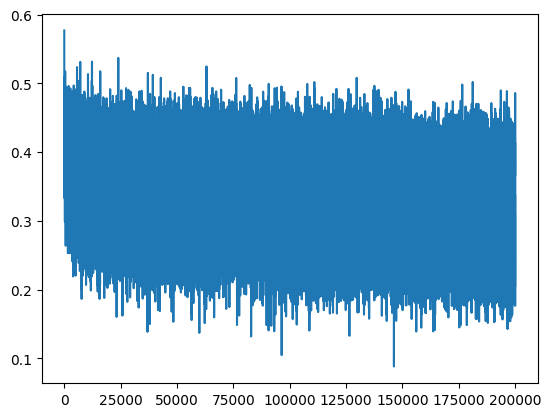

In [11]:
plt.plot(lossi)

In [12]:
# put layers into eval mode (b=needed for batchnorm espcefically)

for layer in model.layers:
    layer.training = False

In [13]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0596275329589844
val 2.1011178493499756


In [14]:
# sample from the model 

for _ in range(20):
    out = []

    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word
    

mexze.
lyse.
gwosen.
marryn.
zorayah.
elson.
taion.
dayah.
ahroyah.
jhanniik.
dacy.
grishalyne.
ebranda.
miliana.
hamby.
dencon.
uhshand.
malizen.
ronnix.
aliana.


In [15]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [16]:
torch.arange(10).view(2,5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [17]:
torch.arange(10).view(-1, 2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [18]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

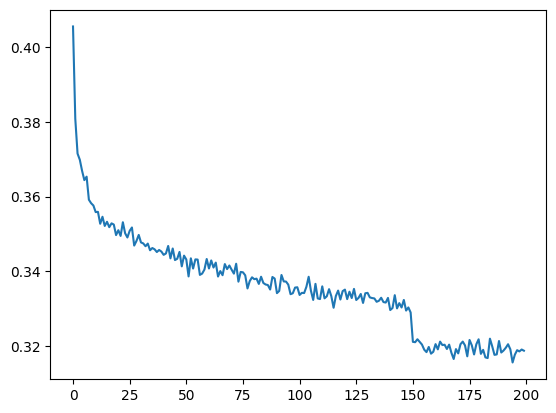

In [19]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

#### performance log

##### original (3 character context + 200 hidden neurons, 12k parameters) : train 2.104, val: 2.132
##### context 3 -> 8 (22k params) train: 2.0596, val: 2.101